<a href="https://colab.research.google.com/github/MarsDana/fakenewsdetectionproject/blob/main/RoBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers[torch]
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.6/336.6 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.2.1
    Uninstalling accelerate-1.2.1:
      Successfully uninstalled accelerate-1.2.1


In [ ]:
import accelerate
from transformers import Trainer, TrainingArguments, TrainerCallback
import torch
import pandas as pd
import random
from torch.utils.data import Dataset
from transformers import RobertaTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import pandas as pd
from sklearn.model_selection import train_test_split

# Load the ISOT datasets
fake_isot = pd.read_csv("/content/drive/MyDrive/datasets/ISOT/Fake.csv")
real_isot = pd.read_csv("/content/drive/MyDrive/datasets/ISOT/True.csv")

# Add labels to the ISOT datasets
real_isot['label'] = 1  # Real news
fake_isot['label'] = 0  # Fake news

# Load the PolitiFact datasets
fake_politifact = pd.read_csv("/content/drive/MyDrive/datasets/fakenewsnet/politifact_fake.csv")
real_politifact = pd.read_csv("/content/drive/MyDrive/datasets/fakenewsnet/politifact_real.csv")

# Add labels to the PolitiFact datasets
real_politifact['label'] = 1  # Real news
fake_politifact['label'] = 0  # Fake news

# Rename the 'title' column to 'text' for consistency with ISOT
real_politifact.rename(columns={'title': 'text'}, inplace=True)
fake_politifact.rename(columns={'title': 'text'}, inplace=True)

# Load the LIAR dataset
liar_dataset = pd.read_csv("/content/drive/MyDrive/datasets/liar_dataset/test.tsv", sep="\t", header=None)

# Rename columns for readability
liar_dataset.columns = ["id", "label", "statement", "subject", "speaker", "job", "state", "party", "barely_true_counts",
                        "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context"]

# Map LIAR dataset labels to binary format
liar_dataset['binary_label'] = liar_dataset['label'].apply(
    lambda x: 1 if x in ["true", "mostly-true", "half-true"] else 0  # Real news: 1, Fake news: 0
)

# Extract relevant columns for consistency
liar_dataset = liar_dataset[["statement", "binary_label"]]
liar_dataset.rename(columns={"statement": "text", "binary_label": "label"}, inplace=True)

# Combine all datasets into a single dataframe
combined_df = pd.concat([real_isot, fake_isot, real_politifact, fake_politifact, liar_dataset], ignore_index=True)

# Shuffle the combined dataframe
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the dataframe into training and validation sets (80/20 split)
train_df, val_df = train_test_split(combined_df, test_size=0.2, random_state=42)



# Reduce the training dataset to 1/3 of its original size
train_df_reduced = train_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=1/3, random_state=42))

# Reduce the validation dataset to 1/3 of its original size
val_df_reduced = val_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=1/3, random_state=42))


# Extract articles (and titles) and labels for training and validation
train_articles = train_df_reduced['text'].tolist()
train_labels = train_df_reduced['label'].tolist()

val_articles = val_df_reduced['text'].tolist()
val_labels = val_df_reduced['label'].tolist()



class TextClassificationDataset(Dataset):
    def __init__(self, articles, labels, tokenizer, max_length):
        self.articles = articles
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.articles)

    def __getitem__(self, idx):
        article = str(self.articles[idx])
        label = int(self.labels[idx])

        # Tokenize the article
        encoding = self.tokenizer(
            article,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label)
        }


from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import numpy as np

# Load pre-trained model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobertaForSequenceClassification.from_pretrained("roberta-base").to(device)
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Create the dataset
train_dataset = TextClassificationDataset(
    articles=train_articles,
    labels=train_labels,
    tokenizer=tokenizer,
    max_length=512  # Adjust based on your model's maximum sequence length
)

# Create the dataset
val_dataset = TextClassificationDataset(
    articles=val_articles,
    labels=val_labels,
    tokenizer=tokenizer,
    max_length=512  # Adjust based on your model's maximum sequence length
)


# Verify the new sizes of the datasets
print(f"Reduced training articles: {len(train_articles)}")
print(f"Reduced validation articles: {len(val_articles)}")

# Define training arguments
training_args = TrainingArguments(
    output_dir="./my_finetuned_model",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=200,
    weight_decay=0.01,
    logging_steps=500,
    logging_dir="./logs",
    fp16=True,
    max_steps=len(train_dataset),
)

# Define a compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision = precision_score(labels, preds, average="weighted")
    recall = recall_score(labels, preds, average="weighted")
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

# Assuming `trainer` is your Trainer instance
results = trainer.evaluate(eval_dataset=val_dataset)
results

<ipython-input-3-c7f764a71d67>:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df_reduced = train_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=1/3, random_state=42))
<ipython-input-3-c7f764a71d67>:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_df_reduced = val_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=1/3, random_state=42))
/usr/local/lib/pytho

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Reduced training articles: 12592
Reduced validation articles: 3148


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Step,Training Loss
500,0.161000
1000,0.083200
1500,0.066900
2000,0.054700
2500,0.055000
3000,0.044100
3500,0.068800
4000,0.040000
4500,0.069000
5000,0.060400


In [ ]:
results

{'eval_loss': 0.042001619935035706,
 'eval_accuracy': 0.9822109275730623,
 'eval_f1': 0.9822163587366911,
 'eval_precision': 0.9825714914059678,
 'eval_recall': 0.9822109275730623,
 'eval_runtime': 32.4033,
 'eval_samples_per_second': 97.151,
 'eval_steps_per_second': 12.159,
 'epoch': 8.0}

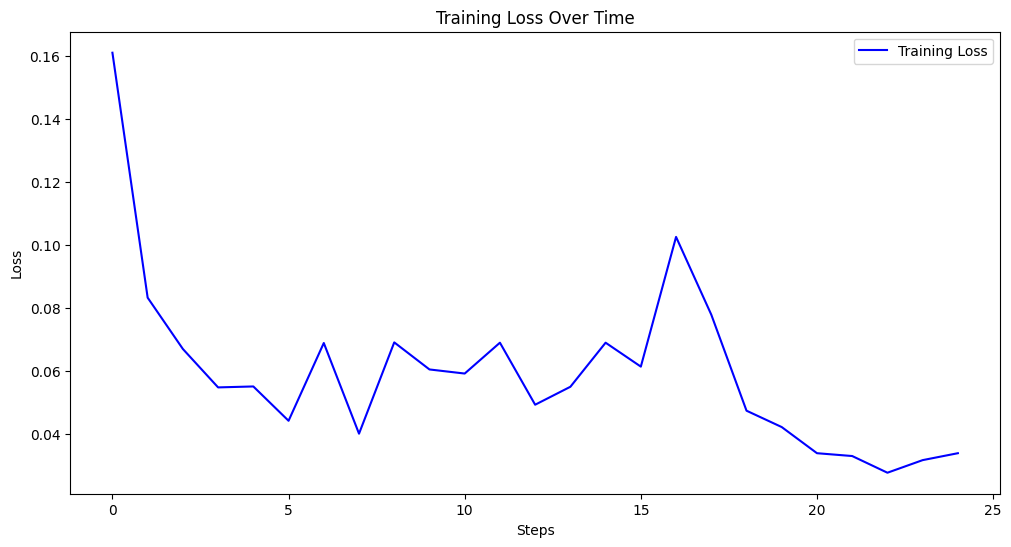

In [ ]:
import matplotlib.pyplot as plt

# Extract training loss and metrics
training_loss = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry]
steps = [entry['step'] for entry in trainer.state.log_history if 'step' in entry]

# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(range(len(training_loss)), training_loss, label='Training Loss', color='blue')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()


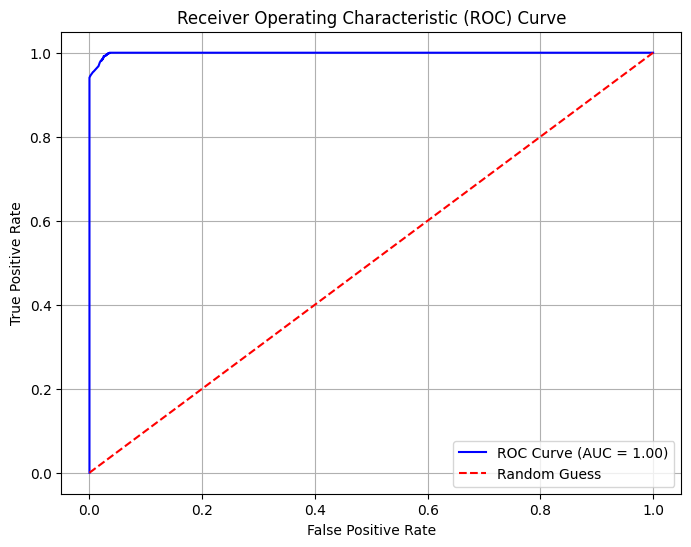

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predictions from the model
predictions = trainer.predict(val_dataset)

# Extract probabilities for the positive class (assuming binary classification)
if predictions.predictions.shape[1] == 2:  # For models with logits
    pred_probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()
else:  # For models with direct probabilities
    pred_probs = predictions.predictions[:, 0]

# Ensure `val_labels` is in the correct format (list or numpy array)
val_labels = np.array(val_labels)

# Calculate ROC-AUC
roc_auc = roc_auc_score(val_labels, pred_probs)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(val_labels, pred_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

